# COVID analysis based on the number of deceased cases

* https://medicalxpress.com/news/2020-04-covid-average-actual-infections-worldwide.html
* https://www.thelancet.com/pdfs/journals/laninf/PIIS1473-3099(20)30243-7.pdf

In [466]:
!pwd
!curl -O https://data.covid19japan.com/summary/latest.json

/Users/hide/_projects/jupyter_notebooks/COVID-19/COVID-modeling
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  101k  100  101k    0     0   144k      0 --:--:-- --:--:-- --:--:--  144k


In [473]:
import pandas as pd
import json
%matplotlib inline

fatality_rate = 0.016
detection_rate = 0.25

def load_data(filepath):
    with open(filepath, 'r') as f:
        data = json.loads(f.read())
    df = pd.DataFrame(data['daily'])
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    columns = [col for col in df.columns if 'Avg' not in col]
    df = df[:-1][columns]  # cut off the last row
    return df

def get_daily(df, column_name):
    return df[column_name] - df[column_name].shift(1)

def append_column(input_df):

    df = input_df.copy()
    df['exitedCumulative'] = df['recoveredCumulative'] + df['deceasedCumulative']
    
    df['dailyTested'] = get_daily(df, 'testedCumulative')
    df['dailyConfirmed'] = get_daily(df, 'confirmedCumulative')
    df['dailyDeceased'] = get_daily(df, 'deceasedCumulative')
    
    df['dailyConfirmedInTestedRate'] = df['dailyConfirmed'] / df['dailyTested']
    
    # Decease base estimated confirmed
    df['estimatedConfirmedCumulative'] = df['deceasedCumulative'].shift(-14) / fatality_rate
    df['detectionRate'] = df['confirmedCumulative'] / df['estimatedConfirmedCumulative']
    df['estimatedConfirmedCumulativeByDetectionRate'] = df['confirmedCumulative'] / detection_rate
    
    return df
    
df = append_column(load_data('latest.json'))
df.tail(3).transpose()

date,2020-04-10,2020-04-11,2020-04-12
confirmed,622.00000,736.000000,489.000000
recoveredCumulative,714.00000,762.000000,784.000000
deceasedCumulative,111.00000,117.000000,123.000000
criticalCumulative,117.00000,122.000000,129.000000
testedCumulative,68771.00000,74891.000000,77381.000000
confirmedCumulative,6212.00000,6948.000000,7437.000000
exitedCumulative,825.00000,879.000000,907.000000
dailyTested,4384.00000,6120.000000,2490.000000
dailyConfirmed,622.00000,736.000000,489.000000
dailyDeceased,5.00000,6.000000,6.000000


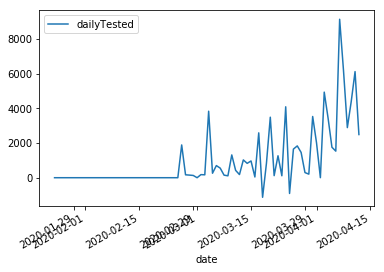

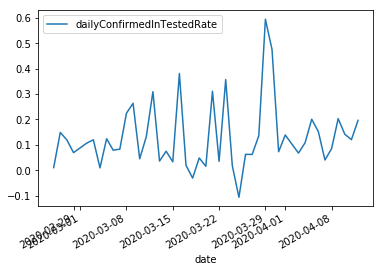

In [484]:
# Check testing rate

display(df[['dailyTested']].plot())
display(df[df['dailyConfirmedInTestedRate']<1][['dailyConfirmedInTestedRate']].plot())

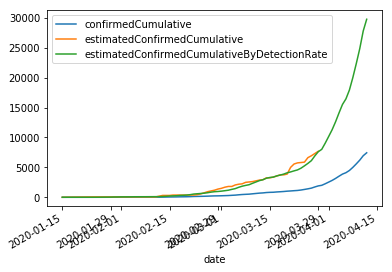

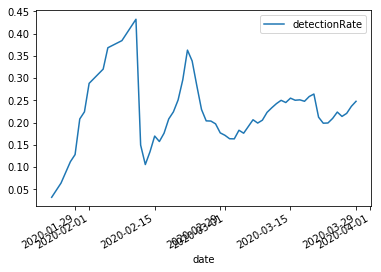

In [485]:
# Perform deceased base analysis

display(df[[
    'confirmedCumulative',
    'estimatedConfirmedCumulative',
    'estimatedConfirmedCumulativeByDetectionRate',
]].plot())

display(df[['detectionRate']].plot())

# Fit the estimated number to SIR model

In [486]:
import json
import pandas as pd

from ddeint import ddeint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from scipy.integrate import odeint

import optuna
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [501]:
# Initial values
N = 126_100_000
I0 = 62
R0 = 0
S0 = N - I0 - R0
init_state = [S0, I0, R0]

def model(Y, t, N, beta, gamma):
    '''SIR Model'''
    S = Y[0]
    I = Y[1]
    R = Y[2]
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return np.array([
        dSdt, dIdt, dRdt
    ])

def create_data_range_and_tt(start_date, end_date):
    date_range = pd.date_range(start_date, end_date, freq='d')
    t_max = len(date_range)
    tt = np.linspace(0.0, t_max-1, t_max)
    return date_range, tt

def objective_with_args(start_date, end_date):
    date_range, tt = create_data_range_and_tt(start_date, end_date)

    def objective(trial):
        beta = trial.suggest_loguniform('beta', 0.001, 0.5)
        gamma = trial.suggest_loguniform('gamma', 0.03, 0.2)
        yy = odeint(model, init_state, tt, args=(N, beta, gamma))
        return (
            mean_squared_error(yy[:,1], df.loc[start_date:end_date]['estimatedConfirmedCumulativeByDetectionRate'])
        )

    return objective

In [500]:
# Date for training
start_date = '2020-02-10'
end_date = '2020-04-11'

optuna.logging.disable_default_handler()
study = optuna.create_study()
study.optimize(objective_with_args(start_date, end_date), n_trials=100)
print("best_value = ", study.best_value)
print("best_params = ", study.best_params)

# Initial values
beta = study.best_params['beta']
gamma = study.best_params['gamma']

print(f'infection rate = {beta}')
print(f'days = {1/gamma}')
print(f'R0 = {beta/gamma}')

best_value =  489538.0398879541
best_params =  {'beta': 0.19390216808166785, 'gamma': 0.09367410166923534}
infection rate = 0.19390216808166785
days = 10.675309206924823
R0 = 2.0699656001649136


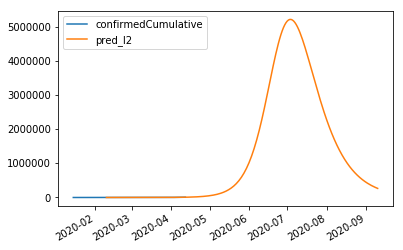

In [503]:
end_date = '2020-09-10'
date_range, tt = create_data_range_and_tt(start_date, end_date)

new_yy = odeint(model, init_state, tt, args=(N, beta, gamma))

def make_df(yy, date_range):
    df = pd.DataFrame(yy[:, 0:3], columns=['pred_S', 'pred_I', 'pred_R'])
    df.index = date_range
    df['pred_D'] = df['pred_I'].shift(14) * fatality_rate
    df['pred_I2'] = df['pred_I'] * detection_rate
    return df

predicted_df = make_df(new_yy, date_range)
df_with_pred = pd.merge(df, predicted_df, how='outer', left_index=True, right_index=True)
df_with_pred[[
#     'estimatedConfirmedCumulative',
#     'estimatedConfirmedCumulativeByDetectionRate',
#     'pred_I',
    'confirmedCumulative',
    'pred_I2',
#     'testedCumulative'
    ]].plot()

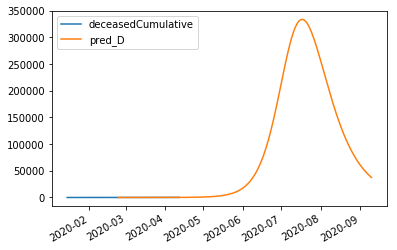

In [504]:
df_with_pred[[
    'deceasedCumulative',
    'pred_D'
    ]].plot()

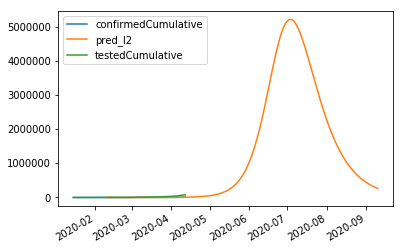

In [505]:
df_with_pred[[
    'confirmedCumulative',
    'pred_I2',
    'testedCumulative'
    ]].plot()